In [1]:
import numpy as np
from myplotstyle import plt, legend_ordered

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
base = Query(C.sat_rcut, "p_sat_corrected > 0").filter(base)
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
with_silver = False

In [5]:
rng = np.random.default_rng()
sample_query = (C.sample_gold | C.sample_silver) if with_silver else C.sample_gold
base_group_by_hosts = sample_query.filter(base, ["HOSTID", "p_sat_corrected"]).group_by("HOSTID")

counts = np.vstack([
    np.bincount([
        np.count_nonzero(base_this["p_sat_corrected"] >= rng.random(size=len(base_this)))
        for base_this in base_group_by_hosts.groups
    ], minlength=25)[:25]
    for _ in range(1000)
])

counts = counts / nhosts
counts_mean = counts.mean(axis=0)
counts_std = np.std(counts, axis=0, ddof=1)

In [6]:
# Column 3 is M*>6.75-0.029, Column 5 is M*>7.5-0.029
nsats_model = np.loadtxt("data/SatNo_var15.txt", usecols=(3 if with_silver else 5)).astype(np.int64)

counts_model = np.vstack([np.bincount(rng.choice(nsats_model, nhosts), minlength=25)[:25] for _ in range(1000)])
counts_model = counts_model / nhosts
counts_model_mean = counts_model.mean(axis=0)
counts_model_std = np.std(counts_model, axis=0, ddof=1)

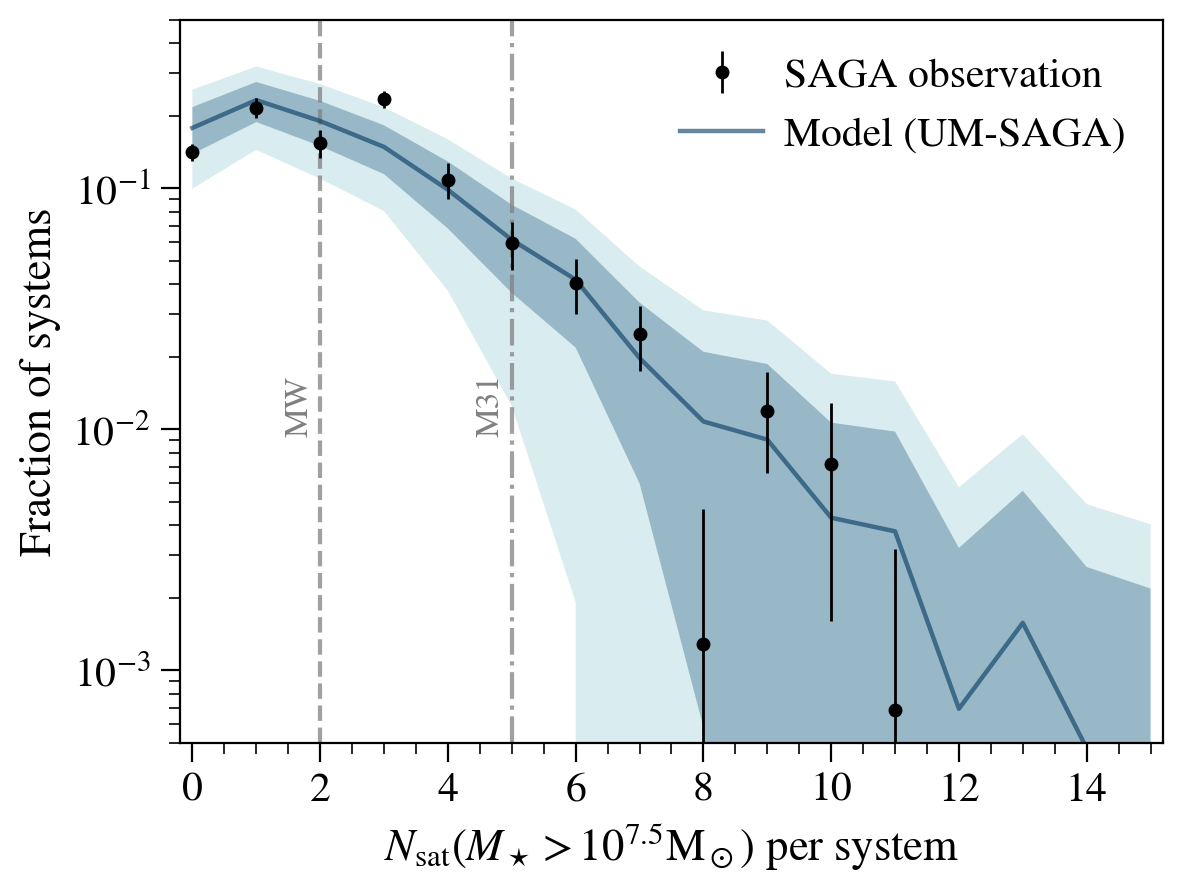

In [7]:
n = 21 if with_silver else 16
x = np.arange(n)

# SAGA3
plt.errorbar(x, counts_mean[:n], yerr=counts_std[:n], marker="o", ms=4, ls="", color="k", lw=1, zorder=90, label="SAGA observation")

# UM on c125-2048
plt.plot(x, counts_model_mean[:n], color="#003660", lw=1.6, alpha=0.6, label=r"Model (UM-SAGA)")
plt.fill_between(x, counts_model_mean[:n] - counts_model_std[:n], counts_model_mean[:n] + counts_model_std[:n], facecolor="#003660",alpha=0.3, lw=0.0, rasterized=True)
plt.fill_between(x, counts_model_mean[:n] - 2*counts_model_std[:n], counts_model_mean[:n] + 2*counts_model_std[:n], facecolor="#04859B",alpha=0.15, lw=0.0, rasterized=True)

# MW
n_mw = 5 if with_silver else 2
plt.axvline(n_mw, c="gray", ls="--", alpha=0.75, zorder=1)
plt.text(n_mw - 0.55, 0.01, "MW", rotation=90, fontsize=12, color="gray")

# M31
n_m31 = 8 if with_silver else 5
plt.axvline(n_m31, c="gray", ls="-.", alpha=0.75, zorder=1)
plt.text(n_m31 - 0.55, 0.01, "M31", rotation=90, fontsize=12, color="gray")

# Ticks, labels, etc.
plt.xlim(-0.2, n - 0.8)
plt.yscale("log")
plt.ylim(0.0005, 0.5)
plt.xticks(np.arange(0, n, 2))
plt.xlabel(rf"$N_{{\rm sat}} (M_\star > 10^{{{6.75 if with_silver else 7.5}}}{{\rm M}}_\odot)$ per system")
plt.ylabel(r"Fraction of systems")
legend_ordered([1,0], loc="upper right")

plt.savefig("plots/nsat-dist.pdf")